In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [2]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

In [3]:
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)
top_qvina.head()

,CID,qvina,rfscore_qvina
0,MAR-UNI-c84db004-13,-9.0,6.586498
1,BAR-COM-4e090d3a-53,-7.5,7.221692
2,TRY-UNI-714a760b-6,-6.4,6.377253
3,EDJ-MED-c9f55a56-1,-6.2,5.491030
4,LON-WEI-0a73fcb8-7,-7.4,6.677942


In [4]:
## Sort Qvina rescored with RF-Score
#top_rfscore_qvina = rfscore_qvina.sort_values('rfscore_qvina', ascending=False).groupby('CID').head(1)
#pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1')).append(pd.merge(qvina, rfscore_qvina.sort_values('rfscore_qvina', ascending=False).groupby('CID').head(1), on=['CID','pose']))

In [5]:
# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

In [6]:
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)
top_plants.head()

,CID,plants,rfscore_plants
0,EDG-MED-0da5ad92-3,-70.8540,6.885798
1,DAR-DIA-23aa0b97-19,-79.4982,6.852397
2,MAT-POS-590ac91e-22,-70.4662,6.217164
3,LON-WEI-1908424e-3,-90.5268,7.534084
4,GIA-UNK-30c7cb75-1,-76.6202,6.839672


In [7]:
# Sort PLANTS rescored with RF-Score
#top_rfscore_plants = rfscore_plants.sort_values('rfscore_plants', ascending=False).groupby('CID').head(1)

In [8]:
# Read experimental data
exp = pd.read_csv('activity_data.csv')
exp = exp[['CID','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_50_uM','f_avg_IC50']]
exp.head()

,CID,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50
0,MAT-POS-1e5f28a7-1,NaN,17.091397,NaN,23.712295
1,MAT-POS-e10a589d-1,NaN,99.000000,NaN,0.326703
2,MAT-POS-e10a589d-4,NaN,NaN,NaN,15.730897
3,MAT-POS-1e0c1c67-1,NaN,99.000000,NaN,2.400602
4,MAT-POS-6da3605a-1,NaN,99.000000,NaN,99.500000


In [9]:
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, exp)

In [10]:
# Normalize scores
top['plants'] /= 10
top[['rfscore_qvina','rfscore_plants']] *= -1

In [11]:
import pingouin as pg

In [12]:
for SF in ['qvina','rfscore_qvina','plants','rfscore_plants']:
    df = top[(top['r_avg_IC50'] > 0) & (top['r_avg_IC50'] < 10) & (top[SF] < 0)]
    print(f'{SF}: {pg.corr(df[SF], df["r_avg_IC50"], method="shepherd")["r2"].item():.4f}')

qvina: 0.0323
rfscore_qvina: 0.0115
plants: 0.0859
rfscore_plants: 0.0667


In [13]:
# Sem remover outliers
for SF in ['qvina','rfscore_qvina','plants','rfscore_plants']:
    print(f'{SF}: {pg.corr(top[SF], top["r_avg_IC50"], method="shepherd")["r2"].item():.4f}')

qvina: 0.0293
rfscore_qvina: 0.0315
plants: 0.0048
rfscore_plants: 0.0340


In [14]:
descriptors = pd.read_csv('descriptors.csv')

In [15]:
data = pd.merge(top, descriptors)
data.rename({'VABC Volume Descriptor': 'Volume', 'Rotatable Bonds Count': 'Rotatable Bonds', 'Topological Polar Surface Area': 'TPSA'}, axis=1, inplace=True)

In [16]:
data.head()

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP
0,MAR-UNI-c84db004-13,-9.0,-6.586498,-8.59230,-7.447876,0.000000,NaN,NaN,NaN,424.84863706529114,6,111.52,510.131468,5.100
1,BAR-COM-4e090d3a-53,-7.5,-7.221692,-8.38857,-7.340981,0.000000,NaN,16.960570,NaN,275.6888879402175,6,93.21,312.122240,-0.187
2,TRY-UNI-714a760b-6,-6.4,-6.377253,-6.87197,-6.414523,NaN,13.895165,81.756960,24.566619,231.72693004306151,5,41.99,260.071641,2.401
3,EDJ-MED-c9f55a56-1,-6.2,-5.491030,-6.94555,-6.042434,4.870901,NaN,0.403773,NaN,206.5538721380282,5,70.67,230.116761,1.169
4,LON-WEI-0a73fcb8-7,-7.4,-6.677942,-7.34504,-6.826287,58.930356,66.350807,84.229060,13.671987,271.54289399511737,5,71.45,318.077120,1.647


In [17]:
data[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69768
f_inhibition_at_50_uM,0.69768,1.00000


In [18]:
data.dropna(subset=['r_inhibition_at_50_uM'], inplace=True)
data['Active'] = data['r_inhibition_at_50_uM'] > 50
data['Active'] = data['Active'].astype(int) # 1 para ativo, 0 para inativo

In [19]:
subset = ['qvina','rfscore_qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']
data.dropna(subset=subset, inplace=True)
data['Active'].value_counts()

0    604
1    136
Name: Active, dtype: int64

# Split train and test variables

In [20]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import cross_validate

In [21]:
y = data['Active']
X = data[subset].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

# Dummy classifier

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', metrics.accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.7837837837837838


In [24]:
from sklearn.metrics import roc_curve

In [25]:
def predict(X_train, y_train, method='lr'):
    if method == 'rf':
        model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    elif method == 'svm':
        model = SVC(kernel='linear').fit(X_train, y_train)
    else:
        model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    
    #model_probs = model.predict_proba(X_test)
    #fpr, tpr, _ = roc_curve(y_test, model_probs)
    #plt.plot(fpr, tpr)
    #plt.title(method)
    
    return model.predict(X_test)

def print_metrics(y_test, y_pred):
    print(f'accuracy_score: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'f1_score: {metrics.f1_score(y_test, y_pred)}')
    print(f'recall_score: {metrics.recall_score(y_test, y_pred)}\n')

## Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [26]:
from sklearn.model_selection import cross_validate

In [27]:
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']
scoring_test=['test_' + s for s in scoring_metrics]

## Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr = LogisticRegression(solver='liblinear')
pd.DataFrame(cross_validate(lr, X, y, scoring=scoring_metrics))[scoring_test].mean()

test_accuracy     0.824324
test_f1           0.290983
test_precision    0.614646
test_recall       0.198413
test_roc_auc      0.759954
dtype: float64

## Random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rfc = RandomForestClassifier(n_estimators=10)
pd.DataFrame(cross_validate(rfc, X, y, scoring=scoring_metrics))[scoring_test].mean()

test_accuracy     0.810811
test_f1           0.227295
test_precision    0.462576
test_recall       0.154233
test_roc_auc      0.621226
dtype: float64

## KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(n_neighbors=5)
pd.DataFrame(cross_validate(knn, X, y, scoring=scoring_metrics))[scoring_test].mean()

test_accuracy     0.790541
test_f1           0.193078
test_precision    0.334269
test_recall       0.139683
test_roc_auc      0.647419
dtype: float64

## SVM

In [34]:
from sklearn.svm import SVC

In [35]:
svm = SVC(kernel='linear')
pd.DataFrame(cross_validate(svm, X, y, scoring=scoring_metrics))[scoring_test].mean()

/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caio/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: Undefi

test_accuracy     0.816216
test_f1           0.013793
test_precision    0.100000
test_recall       0.007407
test_roc_auc      0.757624
dtype: float64

# Oversample minority class

In [36]:
from sklearn.utils import resample

In [37]:
y = data['Active']
X = data[subset].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

X = pd.DataFrame(X_train, columns=subset).join(y_train)
active = X.query('Active == 1')
inactive = X.query('Active == 0')

new_active = resample(active, replace=True, n_samples=len(inactive), random_state=27) 
upsampled = pd.concat([inactive, new_active])
upsampled['Active'].value_counts()

1.0    270
0.0    270
Name: Active, dtype: int64

In [38]:
upsampled

,qvina,rfscore_qvina,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,Active
0,-7.6,-6.86693,369.55535800282456,7,43.78,370.239,3.517,0.0
1,-6.5,-5.93428,248.90129801675593,6,38.33,255.126,2.977,0.0
3,-6.8,-6.70817,258.7849490580029,10,81.44,334.06,2.623,0.0
5,-6.6,-5.93379,243.86204774367437,7,41.99,296.053,3.156,0.0
6,-7.3,-6.87178,315.78920321895714,5,75.02,337.182,2.265,0.0
...,...,...,...,...,...,...,...,...
394,-7.5,-6.69777,336.1791334597853,4,65.64,363.158,3.564,1.0
261,-6.6,-6.42551,256.04735744942843,5,41.99,266.142,2.844,1.0
457,-5.9,-7.15273,430.07598936485266,15,71.53,423.252,4.237,1.0
502,-5.6,-5.60961,214.4630217489226,3,51.22,232.121,0.162,1.0


In [39]:
y_train = upsampled['Active']
X_train = upsampled.drop('Active', axis=1)

lr_pred = predict(X_train, y_train, method='lr')
print('Logistic Regression')
print_metrics(y_test, lr_pred)

rfc_pred = predict(X_train, y_train, method='rf')
print('Random Forest')
print_metrics(y_test, rfc_pred)

svm_pred = predict(X_train, y_train, method='svm')
print('SVM')
print_metrics(y_test, svm_pred)

Logistic Regression
accuracy_score: 0.6216216216216216
f1_score: 0.435483870967742
recall_score: 0.675

Random Forest
accuracy_score: 0.6810810810810811
f1_score: 0.03278688524590165
recall_score: 0.025

SVM
accuracy_score: 0.6432432432432432
f1_score: 0.4761904761904763
recall_score: 0.75



# Undersample majority class

In [40]:
new_inactive = resample(inactive, replace=False, n_samples=len(active), random_state=27)
downsampled = pd.concat([new_inactive, active])
downsampled['Active'].value_counts()

1.0    64
0.0    64
Name: Active, dtype: int64

In [41]:
y_train = downsampled['Active']
X_train = downsampled.drop('Active', axis=1)

lr_pred = predict(X_train, y_train, method='lr')
print('Logistic Regression')
print_metrics(y_test, lr_pred)

rfc_pred = predict(X_train, y_train, method='rf')
print('Random Forest')
print_metrics(y_test, rfc_pred)

svm_pred = predict(X_train, y_train, method='svm')
print('SVM')
print_metrics(y_test, svm_pred)

Logistic Regression
accuracy_score: 0.5621621621621622
f1_score: 0.39097744360902253
recall_score: 0.65

Random Forest
accuracy_score: 0.5297297297297298
f1_score: 0.2926829268292683
recall_score: 0.45

SVM
accuracy_score: 0.572972972972973
f1_score: 0.3875968992248062
recall_score: 0.625



# SMOTE (Synthetic Minority Oversampling Technique)

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
y = data['Active']
X = data[subset].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [44]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

lr_pred = predict(X_train, y_train, method='lr')
print('Logistic Regression')
print_metrics(y_test, lr_pred)

rfc_pred = predict(X_train, y_train, method='rf')
print('Random Forest')
print_metrics(y_test, rfc_pred)

svm_pred = predict(X_train, y_train, method='svm')
print('SVM')
print_metrics(y_test, svm_pred)

Logistic Regression
accuracy_score: 0.7513513513513513
f1_score: 0.5106382978723405
recall_score: 0.6

Random Forest
accuracy_score: 0.6972972972972973
f1_score: 0.2
recall_score: 0.175

SVM
accuracy_score: 0.7405405405405405
f1_score: 0.5294117647058822
recall_score: 0.675



# Model evaluation

In [45]:
from sklearn.metrics import roc_curve, auc

[Scoring Function]: [AUC]
qvina: 0.478197
rfscore_qvina: 0.494278
plants: 0.435175
rfscore_plants: 0.498369


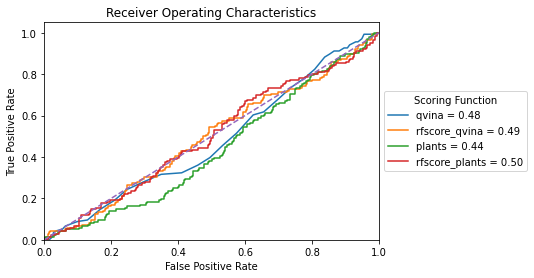

In [46]:
print('[Scoring Function]: [AUC]')
fig, ax = plt.subplots()

for SF in ['qvina','rfscore_qvina','plants','rfscore_plants']:
    # 1st top pose according to each scoring function
    fpr, tpr, _ = roc_curve(data['Active'].to_numpy(), 
                            data[SF].to_numpy())
    roc_auc = auc(fpr, tpr)
    print(f'{SF}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{SF} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', 
       title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))